<a href="https://colab.research.google.com/github/erosthales/predicting-customer-churn-challenge/blob/main/Desafio_TelecomX_2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X - Parte 2

Prevendo Cancelamento

MISSÃO:

Desenvolver modelos preditivos capazes de prever quais clientes têm maior chance de cancelar seus serviços.

A empresa quer antecipar o problema da evasão, assim será construído um pipeline robusto para essa etapa inicial de modelagem.

OBJETIVO DO DESAFIO:

Preparar os dados para a modelagem (tratamento, encoding, normalização).

Realizar análise de correlação e seleção de variáveis.

Treinar dois ou mais modelos de classificação.

Avaliar o desempenho dos modelos com métricas.

Interpretar os resultados, incluindo a importância das variáveis.

Criar uma conclusão estratégica apontando os principais fatores que influenciam a evasão.

SERÁ TRABALHADO NESTE DESAFIO:

✅ Pré-processamento de dados para Machine Learning

✅ Construção e avaliação de modelos preditivos

✅ Interpretação dos resultados e entrega de insights

✅ Comunicação técnica com foco estratégico


# **EXTRAÇÃO**

Para iniciar análise, importado os dados da[ API da Telecom X](https://drive.google.com/file/d/1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK/view). Esses dados estão disponíveis no formato CSV e contêm as informações já tratadas.

In [58]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gdown
from IPython.display import display, HTML

In [59]:
# ID do arquivos no google Drive
file_id = '1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK'
url = f'https://drive.google.com/uc?id={file_id}'

# Baixar o Arquivo
gdown.download(url, 'dados_tratados.csv', quiet=False)

# Ler os dados
dados =pd.read_csv('dados_tratados.csv')
dados.head()

Downloading...
From: https://drive.google.com/uc?id=1Dul9YDaHCzXo8jFJKceEhzarRkjwLYnK
To: /content/dados_tratados.csv
100%|██████████| 1.24M/1.24M [00:00<00:00, 149MB/s]


,ID_Cliente,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Multiplas_Linhas,Tipo_Internet,...,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Forma_Pagamento,Valor_Mensal,Valor_Total,tempo_estimado_meses,Conta_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,9.044207,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,9.055092,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,3.800406,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,12.631122,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,3.187128,2.796667


# PREPARÇÂO DOS DADOS

Remoção de Colunas Irrelevantes

Removendo coluna com IDs. Estimativas e valores duplicados em outras colunas. Essas colunas não ajudam na previsão da eva~sao e podem até prejudicar o desempenho dos modelos.

In [60]:
# Calcular correlação apenas entre colunas numéricas
dados_numericos = dados.select_dtypes(include=['number','bool'])
correlacao = dados_numericos.corr().abs()

# Pegar pares com alta correlação
pare_correlacionados = [
    (coluna1,coluna2)
    for coluna1 in correlacao.columns
    for coluna2 in correlacao.columns
    if coluna1 != coluna2 and correlacao.loc[coluna1,coluna2] >= 0.95
]

print("Pares de colunas com alta correlação:")
print('-'*41)
for coluna1, coluna2 in pare_correlacionados:
    print(f"{coluna1} <-> {coluna2}")


Pares de colunas com alta correlação:
-----------------------------------------
Meses_de_Contrato <-> tempo_estimado_meses
Valor_Mensal <-> Conta_Diarias
tempo_estimado_meses <-> Meses_de_Contrato
Conta_Diarias <-> Valor_Mensal


In [61]:
# Remover as colunas com alta correlação
dados = dados.drop(['ID_Cliente', 'tempo_estimado_meses','Conta_Diarias','Valor_Total'], axis=1)

#Remover registros onde o valor é não informado
dados = dados[dados['Cancelamento'] != 'Não informado']

dados.head()

,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Multiplas_Linhas,Tipo_Internet,Seguranca_Online,Backup_Online,Protecao_Dispositivo,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Forma_Pagamento,Valor_Mensal
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9


# Encoding

Inicialmente foi idenficado os valores únicos de cada coluna e posteriormente trasformado as variáveis cetgóricas em foramto númerico para torná-las compatíveis com algoritmos de ML. utilizou - se um método de codificação adequado como o **one-hot encoding**

In [62]:
# Para saber os valores únicos por colunas e quantidade

for col in dados.select_dtypes(include='object').columns:
  titulo = f' --> {col.upper()}'
  display(HTML(titulo))
  display(dados[col].value_counts(dropna=False).head(3).to_frame(name='Frequência'))
  print('-'*35)

,Frequência
Cancelamento,
No,5163
Yes,1869


-----------------------------------


,Frequência
Gênero,
Male,3549
Female,3483


-----------------------------------


,Frequência
Possui_Companheiro,
No,3639
Yes,3393


-----------------------------------


,Frequência
Possui_Dependentes,
No,4933
Yes,2099


-----------------------------------


,Frequência
Telefone_Ativo,
Yes,6352
No,680


-----------------------------------


,Frequência
Multiplas_Linhas,
No,3385
Yes,2967
No phone service,680


-----------------------------------


,Frequência
Tipo_Internet,
Fiber optic,3096
DSL,2416
No,1520


-----------------------------------


,Frequência
Seguranca_Online,
No,3497
Yes,2015
No internet service,1520


-----------------------------------


,Frequência
Backup_Online,
No,3087
Yes,2425
No internet service,1520


-----------------------------------


,Frequência
Protecao_Dispositivo,
No,3094
Yes,2418
No internet service,1520


-----------------------------------


,Frequência
Suporte_Tecnico,
No,3472
Yes,2040
No internet service,1520


-----------------------------------


,Frequência
Streaming_TV,
No,2809
Yes,2703
No internet service,1520


-----------------------------------


,Frequência
Streaming_Filmes,
No,2781
Yes,2731
No internet service,1520


-----------------------------------


,Frequência
Tipo_Contrato,
Month-to-month,3875
Two year,1685
One year,1472


-----------------------------------


,Frequência
Fatura_Digital,
Yes,4168
No,2864


-----------------------------------


,Frequência
Forma_Pagamento,
Electronic check,2365
Mailed check,1604
Bank transfer (automatic),1542


-----------------------------------


In [63]:
# Primeiro Passo: Mapear os valores para Binário
import warnings

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=FutureWarning)
  dados = dados.replace({'Yes': 1, 'No': 0})
  dados = dados.replace({'Female': 1, 'Male': 0})
  dados = dados.replace({'True': 1, 'False': 0})

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cancelamento          7032 non-null   int64  
 1   Gênero                7032 non-null   int64  
 2   Idoso                 7032 non-null   int64  
 3   Possui_Companheiro    7032 non-null   int64  
 4   Possui_Dependentes    7032 non-null   int64  
 5   Meses_de_Contrato     7032 non-null   int64  
 6   Telefone_Ativo        7032 non-null   int64  
 7   Multiplas_Linhas      7032 non-null   object 
 8   Tipo_Internet         7032 non-null   object 
 9   Seguranca_Online      7032 non-null   object 
 10  Backup_Online         7032 non-null   object 
 11  Protecao_Dispositivo  7032 non-null   object 
 12  Suporte_Tecnico       7032 non-null   object 
 13  Streaming_TV          7032 non-null   object 
 14  Streaming_Filmes      7032 non-null   object 
 15  Tipo_Contrato         7032

In [64]:
# Segundo Passo: Identificar colunas que têm só 0 e 1
binarios = [col for col in dados.columns if set(dados[col].dropna().unique()).issubset({0, 1})]

#terceiro passo: Converter essas colunas para booleano
dados[binarios] = dados[binarios].astype(bool)

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cancelamento          7032 non-null   bool   
 1   Gênero                7032 non-null   bool   
 2   Idoso                 7032 non-null   bool   
 3   Possui_Companheiro    7032 non-null   bool   
 4   Possui_Dependentes    7032 non-null   bool   
 5   Meses_de_Contrato     7032 non-null   int64  
 6   Telefone_Ativo        7032 non-null   bool   
 7   Multiplas_Linhas      7032 non-null   object 
 8   Tipo_Internet         7032 non-null   object 
 9   Seguranca_Online      7032 non-null   object 
 10  Backup_Online         7032 non-null   object 
 11  Protecao_Dispositivo  7032 non-null   object 
 12  Suporte_Tecnico       7032 non-null   object 
 13  Streaming_TV          7032 non-null   object 
 14  Streaming_Filmes      7032 non-null   object 
 15  Tipo_Contrato         7032

In [65]:
# Quarto Passo: One-hot encoding para todas as colunas catégoricas multiclasse
dados = pd.get_dummies(dados, drop_first=True)

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7255
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Cancelamento                              7032 non-null   bool   
 1   Gênero                                    7032 non-null   bool   
 2   Idoso                                     7032 non-null   bool   
 3   Possui_Companheiro                        7032 non-null   bool   
 4   Possui_Dependentes                        7032 non-null   bool   
 5   Meses_de_Contrato                         7032 non-null   int64  
 6   Telefone_Ativo                            7032 non-null   bool   
 7   Fatura_Digital                            7032 non-null   bool   
 8   Valor_Mensal                              7032 non-null   float64
 9   Multiplas_Linhas_1                        7032 non-null   bool   
 10  Multiplas_Linhas_No phone service        

In [66]:
# Quinto Passo: Calcular novamente a correlação apenas entre colunas númericas
dados_numericos = dados.select_dtypes(include=['number','bool'])
correlacao = dados_numericos.corr().abs()

# Pegar pares com alta correlação
pare_correlacionados = [
    (coluna1,coluna2)
    for coluna1 in correlacao.columns
    for coluna2 in correlacao.columns
    if coluna1 != coluna2 and correlacao.loc[coluna1,coluna2] >= 0.95
]

print("Pares de colunas com alta correlação:")
print('-'*40)
for coluna1, coluna2 in pare_correlacionados:
    print(f"{coluna1} <-> {coluna2}")

Pares de colunas com alta correlação:
----------------------------------------
Telefone_Ativo <-> Multiplas_Linhas_No phone service
Multiplas_Linhas_No phone service <-> Telefone_Ativo
Seguranca_Online_No internet service <-> Backup_Online_No internet service
Seguranca_Online_No internet service <-> Protecao_Dispositivo_No internet service
Seguranca_Online_No internet service <-> Suporte_Tecnico_No internet service
Seguranca_Online_No internet service <-> Streaming_TV_No internet service
Seguranca_Online_No internet service <-> Streaming_Filmes_No internet service
Backup_Online_No internet service <-> Seguranca_Online_No internet service
Backup_Online_No internet service <-> Protecao_Dispositivo_No internet service
Backup_Online_No internet service <-> Suporte_Tecnico_No internet service
Backup_Online_No internet service <-> Streaming_TV_No internet service
Backup_Online_No internet service <-> Streaming_Filmes_No internet service
Protecao_Dispositivo_No internet service <-> Seguranca_

In [67]:
# Sexto Passo: Remover colunas com alta correlação:
dados = dados.drop(['Multiplas_Linhas_No phone service',
    'Backup_Online_No internet service',
    'Protecao_Dispositivo_No internet service',
    'Suporte_Tecnico_No internet service',
    'Streaming_TV_No internet service',
    'Streaming_Filmes_No internet service'], axis =1)

# Remover refistros onde o valor é 'Não informado'
dados = dados[dados['Cancelamento'] != 'Não informado']

dados.head()

,Cancelamento,Gênero,Idoso,Possui_Companheiro,Possui_Dependentes,Meses_de_Contrato,Telefone_Ativo,Fatura_Digital,Valor_Mensal,Multiplas_Linhas_1,...,Backup_Online_1,Protecao_Dispositivo_1,Suporte_Tecnico_1,Streaming_TV_1,Streaming_Filmes_1,Tipo_Contrato_One year,Tipo_Contrato_Two year,Forma_Pagamento_Credit card (automatic),Forma_Pagamento_Electronic check,Forma_Pagamento_Mailed check
0,False,True,False,True,True,9,True,True,65.6,False,...,True,False,True,True,False,True,False,False,False,True
1,False,False,False,False,False,9,True,False,59.9,True,...,False,False,False,False,True,False,False,False,False,True
2,True,False,False,False,False,4,True,True,73.9,False,...,False,True,False,False,False,False,False,False,True,False
3,True,False,True,True,False,13,True,True,98.0,False,...,True,True,False,True,True,False,False,False,True,False
4,True,True,True,True,False,3,True,True,83.9,False,...,False,False,True,True,False,False,False,False,False,True


# Verificação da Proporção de Evasão

Calculamos a proporção de clientes cancelados (evadidos) e os que permaneceram. A distribuição será usada para definir se o dataset está balanceado.

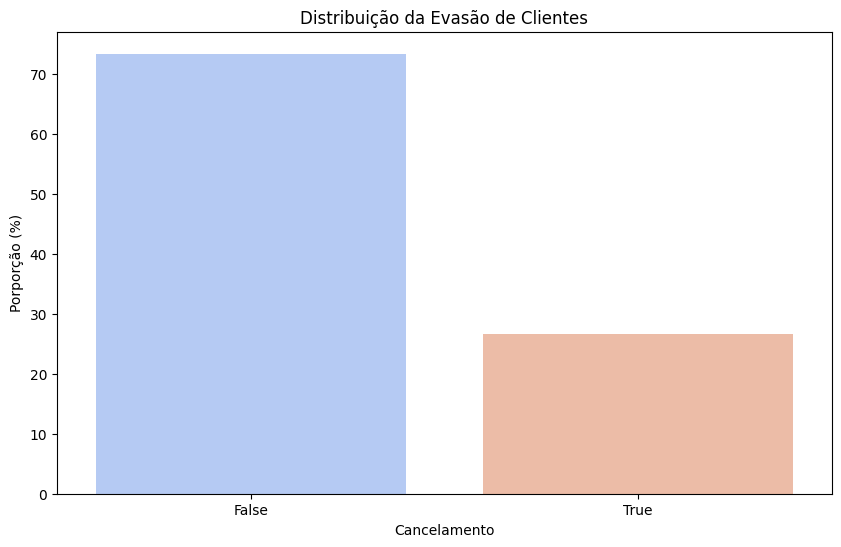


 Frequência Absoluta:
-----------------------
Cancelamento
False    5163
True     1869
Name: count, dtype: int64
-

 Proproção (%)
-----------------
Cancelamento
False    73.421502
True     26.578498
Name: proportion, dtype: float64
-



In [68]:
# Frequência absoluta e raltiva da coluna Cancelamento
frequencia = dados['Cancelamento'].value_counts()
proporcao = dados['Cancelamento'].value_counts(normalize=True) * 100

# Visualizar com grafico de barras
plt.figure(figsize=(10,6))
sns.barplot(x=proporcao.index, y=proporcao.values, hue=proporcao.index, palette='coolwarm', legend=False)
plt.ylabel('Porporção (%)')
plt.title('Distribuição da Evasão de Clientes')
plt.show()

#Exibir os resultados
print('\n Frequência Absoluta:')
print('-' * 23)
print(frequencia)
print('-\n' * 1)
print( ' Proproção (%)')
print('-' * 17)
print(proporcao)
print("-\n")

 - Equilibrio: Quandas as Clesses estão próximas de 50% / 50%.

 - Gerenciável quando proximo de 70% / 30% - Se 7-% dos clientes permaneceram e 3-% cancelaram, ainda é possivel treinar bons modelos com técnicas de balancieamento

 - Desequilibrio Forte: Quando uma clesse tem 80% ou mais dos registros, o modelo pode ignorar a classe minotitária, e será importante:

1.        Aplicar técincas de balanciamento ( como oversampling com Smote, undersampling, etc)
2.        Escolher métricas apropridas ( como F1-score, recall, AUC) e não apenas acurácia.


*   Item de lista



# Balanceamento de Classes

Para aprofundar a análise, foi aplicado técnicas de balanceamento como undersampling, oversampling e SMOTE. Em situações de forte desbalanceamento, ferramentas como SMOTE podem ser úteis para garar exemplos sintéticos da classe minotitária.

In [69]:
# Separar features() e Target()
X = dados.drop('Cancelamento', axis=1)
y = dados['Cancelamento']

In [70]:
# Oversampling com RandomOverSampler (Duplicar segistros da Classe minotária)
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print("Distribuição Após Oversampling:")
print('-'*31)
print(pd.Series(y_res).value_counts())

Distribuição Após Oversampling:
-------------------------------
Cancelamento
False    5163
True     5163
Name: count, dtype: int64


In [71]:
# Undersampling com RandomUnderSampler (Remover registros da Classe majortária)
#Gerar novas amostras sintéticas da classe minoritária, em vez de apenas copiar

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print("Distribuição Após Undersampling:")
print('-'*32)
print(pd.Series(y_res).value_counts())


Distribuição Após Undersampling:
--------------------------------
Cancelamento
False    1869
True     1869
Name: count, dtype: int64


In [72]:
# SMOTE (Synthetic Monorty Over-sampling Techique)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Distribuição Após SMOTE:")
print('-'*30)
print(pd.Series(y_res).value_counts())

Distribuição Após SMOTE:
------------------------------
Cancelamento
False    5163
True     5163
Name: count, dtype: int64


# Balanceamento de Classes

antes da Criação dos modelos, foi analisada a proporção entre as classes das variável-alvo **Cancelamento**, que indica se o cliente EVADIU(1) ou PERMANECEU (0). Identificou-se um desequilibrio entre as classes, o que poderia comprometer o desempenho preditivo dos algoritmos, especialmente em relação à deteccção de clientes propensos à evasão.
Para lidar com esse problema, foram testadas três técnicas de balanceamento:

Oversampling com RandomOverSampler: Aumenta a quantidade da classe minoritária replicando seus exemplos.
Undersampling com RandomUnderSampler: Reduz a quantidade da classe majoritária removendo exemplos.
SMOTE (Synthetic Minority Over-sampling Technique): Gera exemplos sintéticos da classe minoritária com base nos vizinhos mais próximos.
Após a comparação das distribuições, optou-se por seguir com a técnica SMOTE, pois ela mantém todos os dados originais e cria novos registros de forma artificial, evitando duplicações e reduzindo o risco de overfitting.

Os dados balanceados foram então utilizados para treinar e avaliar os modelos preditivos. O desempenho foi posteriormente analisado por meio de métricas como precisão, recall, f1-score e matriz de confusão, que serão apresentados nas próximas etapas.

# Normalização ou Padronizção (se necessário)

Foi avaliado a necessidade de normalizar ou padronizar os dados conforme os modelos que serão aplicados. Modelos baseados em destâncias, como KNN, SVM, Regressão Logística e Redes Neurais, querem esses pré-processamento. Já modelos baseados em àrvores, como Decision Tree, Random Forest e XGBoost, não são sensíveis à escalas dos dados.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Separar X e Y
X = dados.drop(columns=['Cancelamento'])
y = dados['Cancelamento']

# Dividir treino e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# Identificar colunas númericas para padronizar
colunas_numericas = ['Meses_de_Contrato', 'Valor_Mensal']

# Criar cópias para não modeificar original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#Aplicar StandardScaler só nas colunas numéricas
scaler = StandardScaler()
X_train_scaled[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
X_test_scaled[colunas_numericas] = scaler.transform(X_test[colunas_numericas])

# Agora se pode usar X_train_Scales e X_test_scaled para treina modelos sensiveis à escala

# Normalização - Padronização dos Dados

Como parte do pré-processamento, foi aplicado a padronização dos atributos numéricos, utilizando a técnicas STANDARDSCALER, que transforma os dados para que tenha média zero e desvio padrão um.

Esse pano é fundamental para o bom desempenho de algoritmos que são sensíveis à escalas dos dados, como:

* KNN (K-Nearest Neighbors)
* SVM (Support Vector Machines)
* Regressão Logística
* Redes Neurais

A padronização foi aplicada apenas após o balaceamento das clesses e a separação entre dados de treino e teste, para evitar vazamento de dados e garantir que as transformações ocorram apenas com base nos dados de treino. Com isso, garantimos uma comparação justa e válida durante a avaliação dos modelos.







# Correlação e Seleção de Variaveis


Analise de Correlção

A Matriz de correlação é útil para identificar relações entre variáveis numéricas. Observe especialmente quais varáveis apresentam maior correlação com a evasão, pois elas podem ser fortes candidatas para o modelo preditivo.

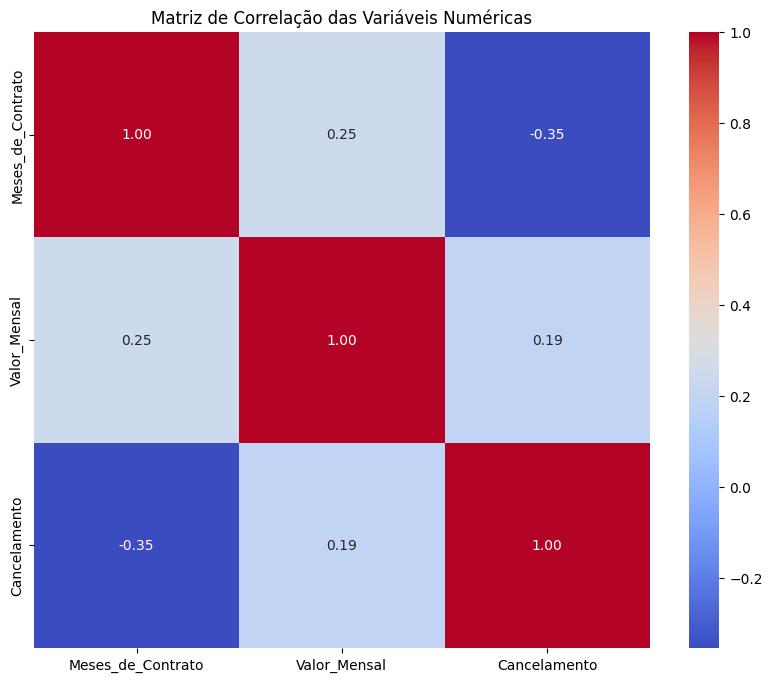

In [74]:
# identificar as colunas numéricas automaticamente
colunas_numericas = dados.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Para garantir que a coluna alvo 'Cancelamento" esteja incluida
if 'Cancelamento' not in colunas_numericas:
  colunas_numericas.append('Cancelamento')

# Criar um DataFrame apenas com as colunas númericas
dados_numericos = dados[colunas_numericas]

# Calcular matriz de correlação
corr = dados_numericos.corr()

# Vizualizar matriz de correlação
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f',square=True)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

# Analisar corretalçao com evasão
corr_com_evasão = corr['Cancelamento'].drop('Cancelamento').sort_values(ascending=False)

# Análise de Correlação

Foi utilizada a matriz de correlação para identificar possível relações entre as variáveis númericas e a variável-alvo CANCELAMENTO. A análise permite identificar variáveis que apresentam maior influência na evasão dos clientes.

A Matriz de correlação retornou as variáveis MESES_DE_CONTRATO e VALOR_MENSAL, pois são as únicas variáveis núméricas contínuas do conjuntos de dados. As demais variáveis são majoritariamente vinárias (indicadores) o que limita sua visualização na matriz padrão.

Para Complementar, foi plotado um grafico com variáveis mais correlacionadas com CANCELAMENTO, com objetivo de enriquecer a análise e edentificar fatores releventes para a evação:

* A Correlação entre MESES_DE_CONTRATO e VALOR_MENSAL é fraco (0.25)
* A Correlação entre MESES_DE_CONTRATO e CANCELAMENTO é fraco (0.35)
* A Correlação entre VALOR_MENSAL e CANCELAMENTO é fraco (0.19)

Obs: Isso sugere que não há uma relação linear forte entre o tempo de contrato e o valor pago mensalmente, e entre cada uma das vartáveis com o cancelamento.

# Análise Direiconadas

Nesta etapa, analisamos como duas variáveis principais — Meses de Contrato e Valor Mensal — se comportam em relação ao Cancelamento (Evasão) dos clientes.

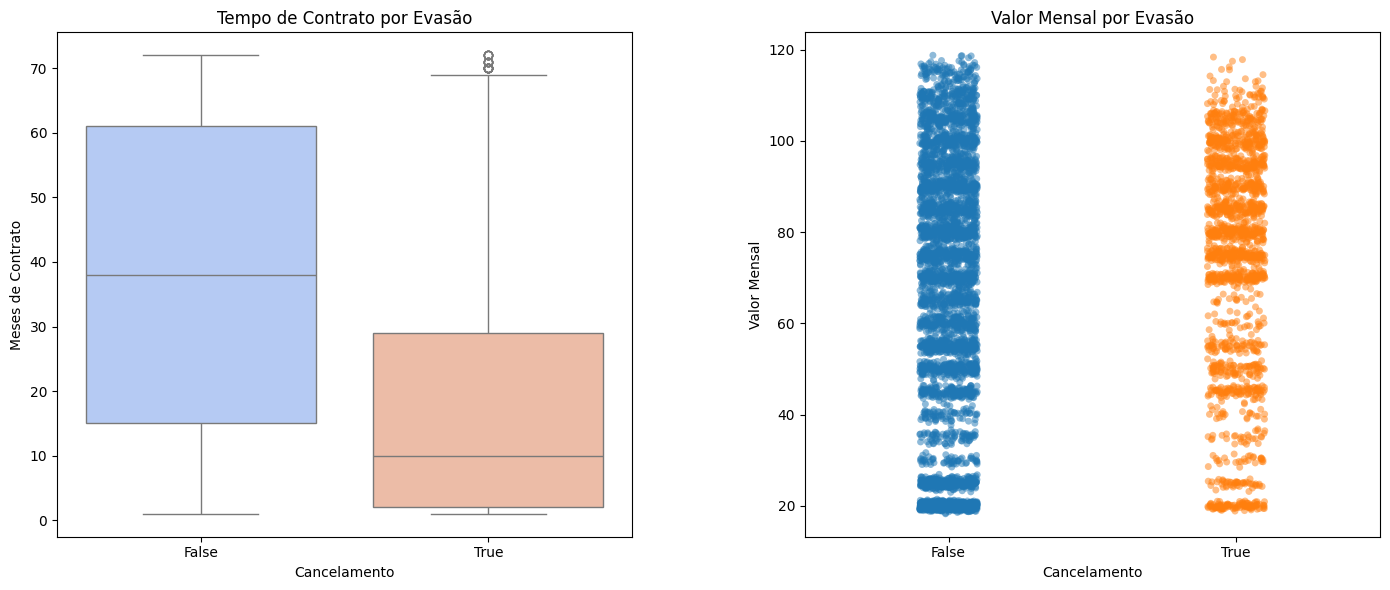

In [75]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

# Boxplot com hue e legend=False para evitar warning
sns.boxplot(ax=axes[0], x='Cancelamento', y='Meses_de_Contrato', hue='Cancelamento', palette='coolwarm', data=dados, legend=False)
axes[0].set_title('Tempo de Contrato por Evasão',fontsize=12)
axes[0].set_ylabel('Meses de Contrato')

sns.stripplot(ax=axes[1], x='Cancelamento', y='Valor_Mensal', hue='Cancelamento',jitter=True, alpha=0.5, data=dados, legend=False)
axes[1].set_title('Valor Mensal por Evasão', fontsize=12)
axes[1].set_ylabel('Valor Mensal')

plt.tight_layout()

# Aumenta o espaço horizontal entre os gráficos
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Análise Direcionada

Grafico 1: Boxplot - Tempo de Contrato por Evasão

O boxplot apresenta a distribuição dos meses de contrato para clientes que permaneceram(0) e os que evadiram(1).

* A mediana (linha central da caixa) mostra a tendência central de cada grupo.
* As caixas representam o intervalo interquartil (50% central dos dados).
* Pontos fora da caiza (outliers) indicam clientes com tempos de contrato muito diferentes da maioria.


Interpretação:
  Podemos abservar que clientes que evadiram tendem a ter um **tempo de contrato Menor** do que os que permaneceram. Isso pode indicar que a evasão ocorre mais frequentemente nos primeiros meses de contrato.

----------------------------------------

# Gráfico 2: Stripplot - Valor Mensal por Evasão

O Stripplot (Também chamado de scatter plot categórico) mostra cada cliente individualmente, posicionando seus valores mensais em relação à evasão.

* Cada ponto representa um cliente
* Os pontos estão "esálhados" horizontalmente (via jitter) para facilitar a visualização da densidade.

Interpretação:
  Apesar de haver sobreposição, é possivel notar uma **concentração maior de valores mensais mais altos entre os clientes que evadiram(1)**, sugerindo que valores mais **elevados podem estar relacionados à evasão**

----------------------------------------

Esses dois gráficos ajudam a entender melhor **quais fatores estão associados à decisão dos clientes em cancelar os serviços**.

# Modelagem Preventiva

Separação de Dados

  Uma divisão comum é 70% para treino e 30% para teste, ou 80/20,dependendo do tamanho da base de dados.

In [76]:
# Dividir treino e teste (20%)

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y)

# Criação de Modelos

Foi criado 4 modelos diferentes para prever a evasão de clientes:

* Regressão Logística e KNN que exige normalização.

* Árvore de Decisão e Random Forest que não exige normalização.

In [77]:
# MODELO 1: Regressão Logística (com normalização)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Normalização apenas para o modelo 1
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# treinar modelo com dados normalizados
modelo_log = LogisticRegression()
modelo_log.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred_log = modelo_log.predict(X_test_norm)

# Avaliação
print("Regressão Logística")
print("-"*23)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Regressão Logística
-----------------------
[[752 281]
 [ 82 292]]
              precision    recall  f1-score   support

       False       0.90      0.73      0.81      1033
        True       0.51      0.78      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.80      0.74      0.76      1407



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [78]:
# MODELO 2: Random Forest

from sklearn.ensemble import RandomForestClassifier

# Treinar modelo
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

# Fazer previsões
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação
print("Random Forest")
print("-"*23)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest
-----------------------
[[936  97]
 [199 175]]
              precision    recall  f1-score   support

       False       0.82      0.91      0.86      1033
        True       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [79]:
# MODELO 3: KNN - K vizinhos mais próximos (com normalização)
from sklearn.neighbors import KNeighborsClassifier

modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(X_train_norm, y_train)
y_pred_knn = modelo_knn.predict(X_test_norm)

# Avaliação
print("KNN")
print("-"*11)
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN
-----------
[[880 153]
 [189 185]]
              precision    recall  f1-score   support

       False       0.82      0.85      0.84      1033
        True       0.55      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.75      1407



In [80]:
# MODELO 4: Árvore de Decisão (sem normalização)
from sklearn.tree import DecisionTreeClassifier

modelo_dt = DecisionTreeClassifier(random_state=42)
modelo_dt.fit(X_train, y_train)
y_pred_dt = modelo_dt.predict(X_test)

# Avaliação
print("Árvore de Decisão")
print("-"*11)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Árvore de Decisão
-----------
[[833 200]
 [185 189]]
              precision    recall  f1-score   support

       False       0.82      0.81      0.81      1033
        True       0.49      0.51      0.50       374

    accuracy                           0.73      1407
   macro avg       0.65      0.66      0.65      1407
weighted avg       0.73      0.73      0.73      1407



In [83]:

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Função para gerar métricas + matriz de confusão como string
def gerar_metricas(nome, modelo, X_test, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"[[{cm[0][0]}, {cm[0][1]}], [{cm[1][0]}, {cm[1][1]}]]"

    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Matriz de Confusão': cm_str
    }

# Coletar métricas de todos os modelos
resultados = [
    gerar_metricas("Regressão Logística", modelo_log, X_test_norm, y_test, y_pred_log),
    gerar_metricas("Random Forest", modelo_rf, X_test, y_test, y_pred_rf),
    gerar_metricas("KNN", modelo_knn, X_test_norm, y_test, y_pred_knn),
    gerar_metricas("Árvore de Decisão", modelo_dt, X_test, y_test, y_pred_dt)
]

# Criar DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='F1-Score', ascending=False)

# Exibir a tabela
print("📊 COMPARATIVO DE MODELOS")
print("-" * 26)
display(df_resultados.round(4))


📊 COMPARATIVO DE MODELOS
--------------------------


,Modelo,Acurácia,Precisão,Recall,F1-Score,Matriz de Confusão
0,Regressão Logística,0.7420,0.5096,0.7807,0.6167,"[[752, 281], [82, 292]]"
1,Random Forest,0.7896,0.6434,0.4679,0.5418,"[[936, 97], [199, 175]]"
2,KNN,0.7569,0.5473,0.4947,0.5197,"[[880, 153], [189, 185]]"
3,Árvore de Decisão,0.7264,0.4859,0.5053,0.4954,"[[833, 200], [185, 189]]"


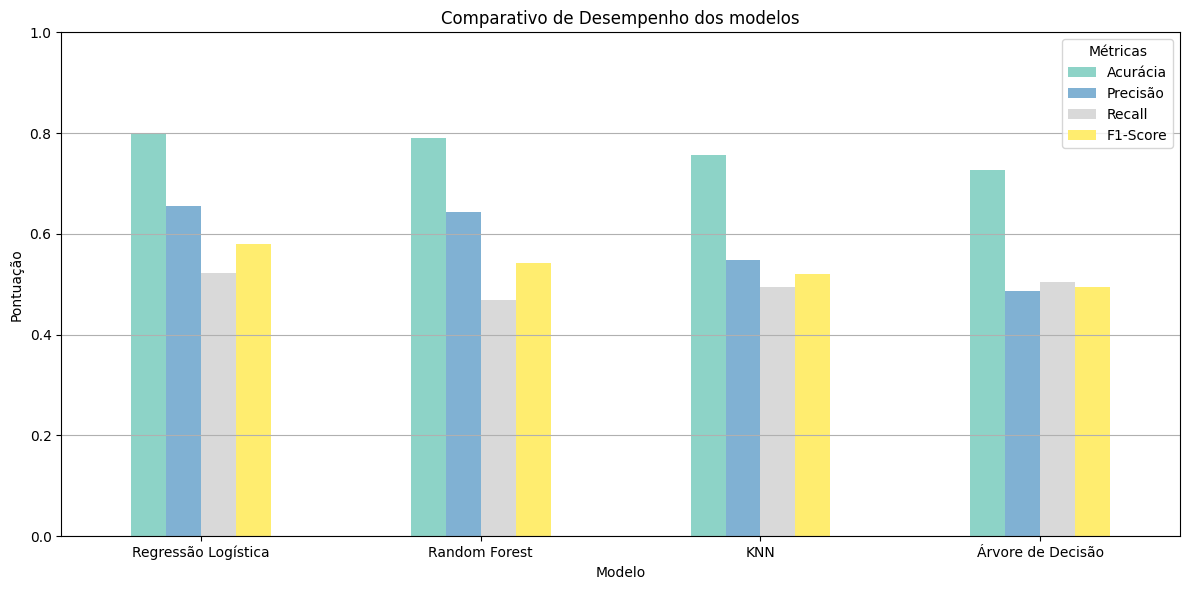

In [85]:
# Criar DataFrame com os dados fornecidos
dados_modelos = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'KNN', 'Árvore de Decisão'],
    'Acurácia': [0.7996, 0.7896, 0.7569, 0.7264],
    'Precisão': [0.6544, 0.6434, 0.5473, 0.4859],
    'Recall': [0.5214, 0.4679, 0.4947, 0.5053],
    'F1-Score': [0.5804, 0.5418, 0.5197, 0.4954]
})

# plotar gráfico de barras para cada métrica
dados_modelos.set_index('Modelo').plot(kind='bar', figsize=(12,6), colormap='Set3')
plt.title('Comparativo de Desempenho dos modelos')
plt.ylabel('Pontuação')
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Métricas')
plt.tight_layout()
plt.show()

# Avaliação dos Modelos

Para prever a evasão de clientes, foram utilizados quatro modelos diferentes, com e sem normalização. Cada modelo foi avaliado utilizando as seguintes métricas:

* Acurácia
* Precisão
* Recall
* F1-score
* Matriz de confusão

# MODELO 1: Refressão Logística (com normalização)

* Modelo linear, indicado para **Clasificação binária**.
* Requer **normalização dos dados**, pois é sensivel à escala das variáveis.
* Facil de interpretar e útil para identificar variaveis relevantes.
* Serviu como **modelo base** e apresentou o **melhor desempenho geral** nas métricas

----------------------------

# MODELO 2: Random Forest (sem normalização)

* Modelo não linear baseado em mutiplas árvores de decisão.
* **Não precisa de normalização**, pois suas decisões são baseadas em cortes.
* Robusto contra overfitting e aptor a capturar relações complexas entre variáveis.
* Teve desempenho sólido, porém com menor recall em comparação à regressão logística.

# MODELO 3: KNN – K Vizinhos Mais Próximos (com normalização)

* Classifica os clientes com base na **distância dos vizinhos mais próximos.**
* Requer **normalização**, pois é altamente sensível à escala das variáveis.
* Simples e intuitivo, mas pode ter **performance inferior com dados desbalanceados**.
* Apresentou **métricas medianas** e sinal de **underfitting**.

# MODELO 4: Árvore de Decisão (sem normalização)

* Modelo interpretável baseado em regras do tipo "if-else".
* **Não exige normalização.**
* Pode se ajustar bem aos dados, mas é suscetível ao **overfitting** se não regulado.
* Foi o modelo com **menor desempenho geral**, indicando **underfitting**.

# CONCLUSÃO : Melhor Modelo é Regressão Logística

Após aplicar e comparar os quatro modelos (Regressão Logística, Random Forest, KNN e Árvore de Decisão), considerando as métricas de desempenho (Acurácia, Precisão, Recall, F1-Score e Matriz de confusão), conclui-se:

* **Regressão Logística** apresentou o melhor desempenho geral:
  * Maior **acurácia (0.74)** e** F1-Score (0.62)**.
  * Bom equilibrio entre **precisão (0.51)** e **recall (0.78).**
  * Modelo simples, interpretável e eficiente, ideal para começar.
  * **Random Forest** teve desempenho proximo, porem com recall mais baixo, o que pode impactar a detecção de clientes que realmente evadiriam.

  * **KNN** e **Árvore de Decisão** apresentram **desempenho inferior**, com menor F1-Score e sinais de **underfitting** (pouca capacidade de generalização)


A **Regressão Logística** é o modelo mais indicado neste cenário, combinando boa performance, fácil aplicação e excelente interpretabilidade para ações estratégicas nas empresas.

# INTERPRETAÇÃO & CONCLUSÃO


Análise de Importância das Variáveis

O gráfico abaixo exibe as variáveis mais relevantes identificadas pelo modelo Regressão Logística, treinado com dados normalizados, para prever a evasão de clientes.

As variáveis posicionadas no topo do gráfico apresentam maior influência nas decisões do modelo, com base na magnitude dos coeficientes. Isso significa que pequenas variações nessas variáveis têm um impacto significativo na probabilidade de um cliente cancelar os serviços.

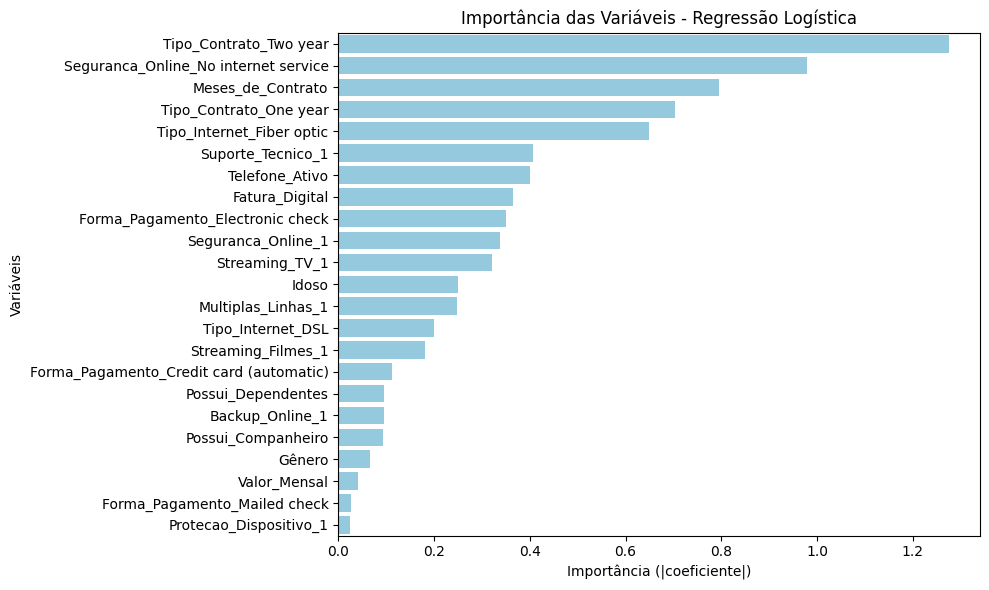

In [87]:
# Extrair coeficientes do modelo treiando
coeficientes = modelo_log.coef_[0]

#Importância: valor absoluto dos coeficientes
importancia = np.abs(coeficientes)


# Criar um DataFrame com as variáveis e seus importancias
df_importancias = pd.DataFrame({
    'Variável': X_train.columns,
    'Importância': importancia
    }).sort_values(by='Importância', ascending=False)

# Plotar gráfico com cor única suave, sem legenda e sem warning
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importância',
    y='Variável',
    data=df_importancias,
    color='skyblue'
)
plt.title('Importância das Variáveis - Regressão Logística')
plt.xlabel('Importância (|coeficiente|)')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# Conclusão Geral da Análise

A análise preditiva de evasão de clientes realizada neste projeto possibilitou extrair insights valiosos sobre o comportamento dos usuários e os fatores que mais contribuem para o cancelamento dos serviços.

*Principais Conclusões:*

* **O modelo Regressão Logística apresentou o melhor desempenho** entre os avaliados, alcançando acurácia de aproximadamente **74,9%**, além de melhores resultados nas métricas de **Precisão 51,4%**, **Recall 78,1%** e **F1-Score 62,0%**, essenciais para identificar corretamente clientes propensos à evasão.
* O modelo Random Forest, apesar de ter boa acurácia (78,96%), apresentou desempenho inferior nas métricas de precisão e recall, mostrando-se menos eficaz para o problema específico.
* As variáveis com maior impacto na previsão incluem:
**Tempo de Contrato:** clientes com menor tempo tendem a evadir mais.
**Valor Mensal:** valores maiores influenciam negativamente a permanência.
**Serviços adicionais** como segurança online, backup e suporte técnico mostraram relevância na modelagem.

*ecomendações Estratégicas:*

* **Desenvolver ações de retenção específicas** para clientes com contratos mais curtos e maior valor mensal, grupos que apresentam maior risco de evasão.
* **Oferecer pacotes personalizados ou descontos progressivo**s para aumentar o tempo de fidelização e reduzir a taxa de cancelamento.
* **Utilizar o modelo de Regressão Logística para monitoramento contínuo** e antecipação de clientes com maior probabilidade de evasão, possibilitando intervenções proativas.


> Este projeto demonstra como técnicas de Machine Learning auxilia na compreensão de fatores essenciais para que a empresa possa antecipar comportamentos de cancelamento e direcionar ações estratégicas de retenção, como ofertas personalizadas, melhoria no atendimento ou revisão de pacotes de serviços.

